<a href="https://colab.research.google.com/github/RingoKid/EuroSAT-DeepLearning/blob/main/ViTxEuroSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess
import sys

# Suppress outputs for pip install
subprocess.run(["pip", "install", "configilm"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
subprocess.run(["pip", "install", "lightning"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
subprocess.run(["pip", "install", "lmdb"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Suppress output for git clone
subprocess.run(["git", "clone", "https://git.tu-berlin.de/rsim/reben-training-scripts.git"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Change directory without output
# os.chdir('/content/reben-training-scripts')
# from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier
sys.path.append('/content/reben-training-scripts')


In [2]:
!pip uninstall -y tensorflow
!pip install tensorflow-cpu

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1


In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.image import resize
from tqdm import tqdm

import json
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import classification_report

from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier
from configilm.extra.BENv2_utils import band_combi_to_mean_std, STANDARD_BANDS

### Initialize the Preprocessor

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
sys.path.append('/content/drive/My Drive/EuroSAT')


In [6]:
from configilm.extra.BENv2_utils import band_combi_to_mean_std, STANDARD_BANDS
from preprocessing import EuroSATPreprocessor, TensorflowToTorchDataset

# Get mean and std for normalization
means, stds = band_combi_to_mean_std(STANDARD_BANDS[10], interpolation="120_nearest")

# Initialize the preprocessor
preprocessor = EuroSATPreprocessor(input_size=120, band_indices=[1, 2, 3, 4, 5, 6, 7, 8, 10, 11], means=means, stds=stds)


In [7]:
# Save the dataset to a specific directory
save_path = '/content/eurosat_dataset'
dataset, info = tfds.load("eurosat/all", split='train', with_info=True, data_dir=save_path)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /content/eurosat_dataset/eurosat/all/incomplete.R99YXX_2.0.0/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /content/eurosat_dataset/eurosat/all/2.0.0. Subsequent calls will reuse this data.


In [8]:
# Inspect dataset labels
for sample in dataset.take(5):  # Inspect 5 samples
    label = sample['label']
    print("Label Type:", type(label.numpy()))
    print("Label Shape:", label.shape)
    print("Label Value:", label.numpy())
    print("-" * 30)


Label Type: <class 'numpy.int64'>
Label Shape: ()
Label Value: 8
------------------------------
Label Type: <class 'numpy.int64'>
Label Shape: ()
Label Value: 4
------------------------------
Label Type: <class 'numpy.int64'>
Label Shape: ()
Label Value: 5
------------------------------
Label Type: <class 'numpy.int64'>
Label Shape: ()
Label Value: 5
------------------------------
Label Type: <class 'numpy.int64'>
Label Shape: ()
Label Value: 3
------------------------------


EuroSAT dataset is multi class

In [9]:
# Apply preprocessing using map
def preprocess_sample(sample):
    """Preprocess a single sample using the EuroSATPreprocessor."""
    return preprocessor.preprocess_sample(sample)

# Preprocess the entire dataset
preprocessed_dataset = dataset.map(preprocess_sample, num_parallel_calls=tf.data.AUTOTUNE)

# Check a preprocessed sample
for sample in preprocessed_dataset.take(1):
    print("Filename:", sample['filename'].numpy())
    print("Image Shape:", sample['sentinel2'].shape)
    print("Label:", sample['label'].numpy())

Filename: b'River_15.tif'
Image Shape: (120, 120, 10)
Label: 8


In [10]:
# Convert TensorFlow dataset to PyTorch dataset
torch_dataset = TensorflowToTorchDataset(preprocessed_dataset)

# Calculate dataset sizes for train, validation, and test splits
dataset_size = len(torch_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensures no data is left out

# Set the random seed for reproducibility
torch.manual_seed(42)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(torch_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check a batch from the train_loader
for images, labels in train_loader:
    print("Batch Image Shape:", images.shape)  # [batch_size, channels, height, width]
    print("Batch Label Shape:", labels.shape)  # [batch_size]
    break


Batch Image Shape: torch.Size([64, 10, 120, 120])
Batch Label Shape: torch.Size([64])


In [11]:
for _, labels in train_loader:
    print("Label Shape:", labels.shape)
    print("Sample Label:", labels[0])
    break


Label Shape: torch.Size([64])
Sample Label: tensor(1)


In [ ]:
for images, labels in train_loader:
    print(f"Image Shape: {images.shape}")  # [batch_size, channels, height, width]
    print(f"Label Shape: {labels.shape}")  # [batch_size]
    print(f"Sample Labels: {labels[:5]}")
    break


Image Shape: torch.Size([64, 10, 120, 120])
Label Shape: torch.Size([64])
Sample Labels: tensor([7, 1, 8, 5, 8])


### Loading the pre trained model

In [12]:
model = BigEarthNetv2_0_ImageClassifier.from_pretrained(
  "BIFOLD-BigEarthNetv2-0/vit_base_patch8_224-s2-v0.1.1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
model.config

ILMConfiguration(timm_model_name='vit_base_patch8_224', hf_model_name=None, image_size=120, channels=10, classes=19, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18'], network_type=0, visual_features_out=512, fusion_in=512, fusion_out=512, fusion_hidden=256, v_dropout_rate=0.25, t_dropout_rate=0.25, fusion_dropout_rate=0.25, _fusion_method='torch.mul', _fusion_activation='nn.Tanh()', drop_rate=0.15, drop_path_rate=0.15, use_pooler_output=True, max_sequence_length=32, load_pretrained_timm_if_available=False, load_pretrained_hf_if_available=True, custom_fusion_method=None, custom_fusion_activation=None)

In [ ]:
model

BigEarthNetv2_0_ImageClassifier(
  (model): ConfigILM(
    (vision_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(10, 768, kernel_size=(8, 8), stride=(8, 8))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): 

#### Freeze N Layers

In [49]:
def unfreeze_last_n_blocks(model, num_unfreeze_blocks, num_classes=10):
    """
    Unfreeze the last N blocks of the Vision Transformer model and update the classification head.

    Args:
        model: The Vision Transformer model (BigEarthNetv2_0_ImageClassifier).
        num_unfreeze_blocks: Number of blocks to unfreeze.
        num_classes: Number of output classes for classification.
    """
    # Reference to the blocks in the Vision Transformer
    vit_blocks = model.model.vision_encoder.blocks
    total_blocks = len(vit_blocks)

    # Freeze all parameters by default
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last N blocks
    for i in range(total_blocks - num_unfreeze_blocks, total_blocks):
        for param in vit_blocks[i].parameters():
            param.requires_grad = True

    # Update and unfreeze the final classification head to have num_classes outputs
    in_features = model.model.vision_encoder.head.in_features
    new_head = nn.Linear(in_features, num_classes)

    # Initialize the new classification head
    nn.init.xavier_uniform_(new_head.weight)
    if new_head.bias is not None:
        nn.init.constant_(new_head.bias, 0)

    # Move the new head to the same device as the model's parameters
    device = next(model.parameters()).device
    new_head = new_head.to(device)

    # Replace the old head with the new one
    model.model.vision_encoder.head = new_head

    # Ensure the new head's parameters are trainable
    for param in model.model.vision_encoder.head.parameters():
        param.requires_grad = True

    print(f"Unfroze the last {num_unfreeze_blocks} blocks and updated the classification head to {num_classes} classes.")

    # Verification: Print trainable parameters and their devices
    trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
    print("Trainable Parameters and their devices:")
    for name in trainable_params:
        param = dict(model.named_parameters())[name]
        print(f"{name}: {param.device}")

In [50]:
# Number of blocks to unfreeze
num_unfreeze_blocks = 3

# Unfreeze the last N blocks
unfreeze_last_n_blocks(model, num_unfreeze_blocks)

# Check if parameters are properly frozen/unfrozen
for name, param in model.named_parameters():
    print(f"{name} - Requires Grad: {param.requires_grad}")


Unfroze the last 3 blocks and updated the classification head to 10 classes.
Trainable Parameters and their devices:
model.vision_encoder.blocks.9.norm1.weight: cuda:0
model.vision_encoder.blocks.9.norm1.bias: cuda:0
model.vision_encoder.blocks.9.attn.qkv.weight: cuda:0
model.vision_encoder.blocks.9.attn.qkv.bias: cuda:0
model.vision_encoder.blocks.9.attn.proj.weight: cuda:0
model.vision_encoder.blocks.9.attn.proj.bias: cuda:0
model.vision_encoder.blocks.9.norm2.weight: cuda:0
model.vision_encoder.blocks.9.norm2.bias: cuda:0
model.vision_encoder.blocks.9.mlp.fc1.weight: cuda:0
model.vision_encoder.blocks.9.mlp.fc1.bias: cuda:0
model.vision_encoder.blocks.9.mlp.fc2.weight: cuda:0
model.vision_encoder.blocks.9.mlp.fc2.bias: cuda:0
model.vision_encoder.blocks.10.norm1.weight: cuda:0
model.vision_encoder.blocks.10.norm1.bias: cuda:0
model.vision_encoder.blocks.10.attn.qkv.weight: cuda:0
model.vision_encoder.blocks.10.attn.qkv.bias: cuda:0
model.vision_encoder.blocks.10.attn.proj.weight: cu

#### Update the Final Layer

In [ ]:
# Update the final classification head for 10 classes
model.model.vision_encoder.head = nn.Linear(in_features=768, out_features=10)

# Check if the layer is updated
print(model.model.vision_encoder.head)

Linear(in_features=768, out_features=10, bias=True)


In [ ]:
model

BigEarthNetv2_0_ImageClassifier(
  (model): ConfigILM(
    (vision_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(10, 768, kernel_size=(8, 8), stride=(8, 8))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): 

#### Early Stopping

In [51]:
# Verify that all trainable parameters are on the correct device
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print("Trainable Parameters and their devices:")
for name in trainable_params:
    param = dict(model.named_parameters())[name]
    print(f"{name}: {param.device}")


Trainable Parameters and their devices:
model.vision_encoder.blocks.9.norm1.weight: cuda:0
model.vision_encoder.blocks.9.norm1.bias: cuda:0
model.vision_encoder.blocks.9.attn.qkv.weight: cuda:0
model.vision_encoder.blocks.9.attn.qkv.bias: cuda:0
model.vision_encoder.blocks.9.attn.proj.weight: cuda:0
model.vision_encoder.blocks.9.attn.proj.bias: cuda:0
model.vision_encoder.blocks.9.norm2.weight: cuda:0
model.vision_encoder.blocks.9.norm2.bias: cuda:0
model.vision_encoder.blocks.9.mlp.fc1.weight: cuda:0
model.vision_encoder.blocks.9.mlp.fc1.bias: cuda:0
model.vision_encoder.blocks.9.mlp.fc2.weight: cuda:0
model.vision_encoder.blocks.9.mlp.fc2.bias: cuda:0
model.vision_encoder.blocks.10.norm1.weight: cuda:0
model.vision_encoder.blocks.10.norm1.bias: cuda:0
model.vision_encoder.blocks.10.attn.qkv.weight: cuda:0
model.vision_encoder.blocks.10.attn.qkv.bias: cuda:0
model.vision_encoder.blocks.10.attn.proj.weight: cuda:0
model.vision_encoder.blocks.10.attn.proj.bias: cuda:0
model.vision_encod

In [39]:
class EarlyStopping:
    def __init__(self, patience=3, monitor="val_loss", mode="min"):
        """
        Initializes the EarlyStopping object.

        Args:
            patience (int): How long to wait after last time monitored metric improved.
            monitor (str): Which metric to monitor ('val_loss', 'val_accuracy', etc.).
            mode (str): 'min' to minimize the monitored metric, 'max' to maximize.
        """
        self.patience = patience
        self.monitor = monitor
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.best_score = float('inf') if mode == 'min' else float('-inf')

    def __call__(self, current_value):
        if self.mode == "min":
            if current_value < self.best_score:
                self.best_score = current_value
                self.counter = 0
            else:
                self.counter += 1
        elif self.mode == "max":
            if current_value > self.best_score:
                self.best_score = current_value
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

In [40]:
# Inspect the current classification head
print(model.model.vision_encoder.head)


Linear(in_features=768, out_features=10, bias=True)


In [44]:
import torch
print(torch.__version__)


2.5.1+cu121


In [52]:
# Set hyperparameters
num_epochs = 30
batch_size = 64  # Set batch size to 64
learning_rate = 1e-4
weight_decay = 2e-2  # Slightly increased for better regularization
patience = 5  # Increased patience to allow more epochs before stopping

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Update the classification head and unfreeze 3 layers
num_classes = 10
unfreeze_last_n_blocks(model, num_unfreeze_blocks=3, num_classes=num_classes)

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Choose scheduler: CosineAnnealingLR or ReduceLROnPlateau
# Option 1: CosineAnnealingLR
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,    # Number of epochs for a full cycle
    eta_min=1e-6         # Minimum learning rate
)

# Option 2: ReduceLROnPlateau (Commented out)
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,
#     patience=2,
#     verbose=True,
#     min_lr=1e-6
# )

# Early Stopping Initialization
early_stopper = EarlyStopping(patience=patience, monitor="val_loss", mode="min")

# Initialize GradScaler for AMP
scaler = GradScaler()

# Training loop
best_val_accuracy = 0.0
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training Phase
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed Precision Forward Pass
        try:
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
        except TypeError:
            # If device_type is not supported, fallback to default autocast
            with torch.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

        # Backward Pass with Scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Training Metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, LR: {current_lr:.6f}")

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in tqdm(val_loader, desc="Validation", leave=False):
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            # Mixed Precision Forward Pass
            try:
                with torch.amp.autocast(device_type='cuda'):
                    val_outputs = model(val_images)
                    loss = criterion(val_outputs, val_labels)
            except TypeError:
                # If device_type is not supported, fallback to default autocast
                with torch.amp.autocast():
                    val_outputs = model(val_images)
                    loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()

            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    # Validation Metrics
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_eurosat_model.pth")
        print("Saved Best Model!")

    # Early Stopping Check
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping triggered. Training stopped.")
        break

    # Step the scheduler
    scheduler.step()  # For CosineAnnealingLR
    # scheduler.step(val_loss)  # For ReduceLROnPlateau

print("\nTraining Complete.")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

<ipython-input-52-38cf79a46f14>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Unfroze the last 3 blocks and updated the classification head to 10 classes.
Trainable Parameters and their devices:
model.vision_encoder.blocks.9.norm1.weight: cuda:0
model.vision_encoder.blocks.9.norm1.bias: cuda:0
model.vision_encoder.blocks.9.attn.qkv.weight: cuda:0
model.vision_encoder.blocks.9.attn.qkv.bias: cuda:0
model.vision_encoder.blocks.9.attn.proj.weight: cuda:0
model.vision_encoder.blocks.9.attn.proj.bias: cuda:0
model.vision_encoder.blocks.9.norm2.weight: cuda:0
model.vision_encoder.blocks.9.norm2.bias: cuda:0
model.vision_encoder.blocks.9.mlp.fc1.weight: cuda:0
model.vision_encoder.blocks.9.mlp.fc1.bias: cuda:0
model.vision_encoder.blocks.9.mlp.fc2.weight: cuda:0
model.vision_encoder.blocks.9.mlp.fc2.bias: cuda:0
model.vision_encoder.blocks.10.norm1.weight: cuda:0
model.vision_encoder.blocks.10.norm1.bias: cuda:0
model.vision_encoder.blocks.10.attn.qkv.weight: cuda:0
model.vision_encoder.blocks.10.attn.qkv.bias: cuda:0
model.vision_encoder.blocks.10.attn.proj.weight: cu

Training Loss: 0.6828, Accuracy: 77.75%, LR: 0.000100


Validation Loss: 0.3881, Accuracy: 86.96%
Saved Best Model!

Epoch 2/30


Training Loss: 0.3870, Accuracy: 86.70%, LR: 0.000100


Validation Loss: 0.3525, Accuracy: 88.69%
Saved Best Model!

Epoch 3/30


Training Loss: 0.3419, Accuracy: 88.47%, LR: 0.000099


Validation Loss: 0.3411, Accuracy: 89.16%
Saved Best Model!

Epoch 4/30


Training Loss: 0.3144, Accuracy: 89.33%, LR: 0.000098


Validation Loss: 0.3358, Accuracy: 89.19%
Saved Best Model!

Epoch 5/30


Training Loss: 0.2996, Accuracy: 89.69%, LR: 0.000096


Validation Loss: 0.3228, Accuracy: 89.53%
Saved Best Model!

Epoch 6/30


Training Loss: 0.2894, Accuracy: 90.17%, LR: 0.000093


Validation Loss: 0.3171, Accuracy: 89.98%
Saved Best Model!

Epoch 7/30


Training Loss: 0.2746, Accuracy: 90.64%, LR: 0.000091


Validation Loss: 0.3378, Accuracy: 89.14%

Epoch 8/30


Training Loss: 0.2650, Accuracy: 90.72%, LR: 0.000087


Validation Loss: 0.3286, Accuracy: 89.51%

Epoch 9/30


Training Loss: 0.2564, Accuracy: 90.81%, LR: 0.000084


Validation Loss: 0.3179, Accuracy: 90.12%
Saved Best Model!

Epoch 10/30


Training Loss: 0.2497, Accuracy: 90.97%, LR: 0.000080


Validation Loss: 0.3054, Accuracy: 90.12%

Epoch 11/30


Training Loss: 0.2404, Accuracy: 91.57%, LR: 0.000075


Validation Loss: 0.3301, Accuracy: 89.19%

Epoch 12/30


Training Loss: 0.2370, Accuracy: 91.69%, LR: 0.000071


Validation Loss: 0.3031, Accuracy: 90.47%
Saved Best Model!

Epoch 13/30


Training Loss: 0.2273, Accuracy: 92.15%, LR: 0.000066


Validation Loss: 0.3142, Accuracy: 90.25%

Epoch 14/30


Training Loss: 0.2188, Accuracy: 92.43%, LR: 0.000061


Validation Loss: 0.3062, Accuracy: 90.15%

Epoch 15/30


Training Loss: 0.2110, Accuracy: 92.51%, LR: 0.000056


Validation Loss: 0.3197, Accuracy: 89.51%

Epoch 16/30


Training Loss: 0.2062, Accuracy: 92.78%, LR: 0.000051


Validation Loss: 0.3125, Accuracy: 90.40%

Epoch 17/30


Training Loss: 0.2007, Accuracy: 93.07%, LR: 0.000045


Validation Loss: 0.3044, Accuracy: 90.20%
Early stopping triggered. Training stopped.

Training Complete.
Best Validation Accuracy: 90.47%


In [53]:
# Test evaluation
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_outputs = model(test_images)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()

test_accuracy = 100. * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 90.99%


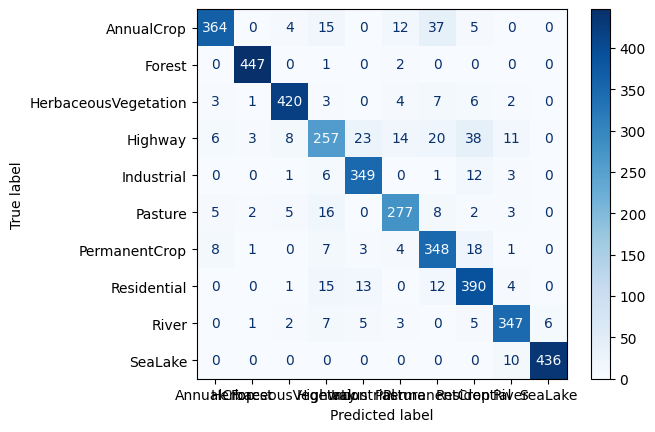

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=info.features['label'].names)
disp.plot(cmap=plt.cm.Blues)
plt.show()